# Setting up a time-varying PDE

In this example we will demonstrate the use of the package on a time-dependent
PDE, a problem of unsteady heat conduction. We will use the package to
solve for the interior diffusion of temperature from a circle held at constant
temperature.

We seek to solve the heat conduction equation with Dirichlet boundary conditions

$$\dfrac{\partial T}{\partial t} = \kappa \nabla^2 T + q + \delta(\chi) \sigma  - \kappa \nabla\cdot \left( \delta(\chi) \mathbf{n} [T] \right)$$

subject to $T = T_b$ on the immersed surface. We might be solving this external
to a surface, or it might be internal. The quantity $\sigma$ is the Lagrange
multiplier. In this context, it is the heat flux through the surface.

In the spatially discrete formulation, the problem takes the form

$$\begin{bmatrix}
\mathcal{L}_C^\kappa & R_C \\ R_C^T & 0
\end{bmatrix}\begin{pmatrix}
T \\ -\sigma
\end{pmatrix} =
\begin{pmatrix}
q - \kappa D_s [T] \\ (T^+_b + T^-_b)/2
\end{pmatrix}$$

where $\mathcal{L}_C^\kappa = \mathrm{d}/\mathrm{d}t - \kappa L_C$, where $[T] = T_b^+ - T_b^-$
is the jump in temperature across the surface. As in the time-independent problems,
we can specify whether we are solving it external or internal to a surface by setting
the boundary value to zero in the other region. However, in contrast to the
time-independent problems, we have to advance this problem in time.
The system above has the form of a *constrained ODE system*, which the `ConstrainedSystems.jl` package treats.
We will make use of this package in the example below.

To support this, there are a few additional steps in our setup of the problem:
- we (as the implementers of the PDE) need to specify the functions that calculate the
   various parts of this constrained ODE system.
- we (as the users of this implementation) need to specify the time step size,
   the initial conditions, the time integration range, and create the *integrator*
   to advance the solution.

The latter of these is very easy, as we'll find. Most of our attention will
be on the first part: how to set up the constrained ODE system. For this,
we will make use of the `ODEFunctionList`, which assembles the
various functions and operators into a `ConstrainedODEFunction`, to be used by the
`ConstrainedSystems.jl` package.

In [1]:
using ImmersedLayers
using Plots
using UnPack

## Set up the constrained ODE system operators
The problem type is generated with the usual macro call. In this example,
we will make use of more of the capabilities of the resulting problem
constructor for "packing" it with information about the problem.

In [2]:
@ilmproblem DirichletHeatConduction scalar

The constrained ODE system requires us to provide functions that calculate
the RHS of the ODE, the RHS of the constraint equation, the Lagrange multiplier force
term in the ODE, and the action of the boundary operator on the state vector.
(You can see the generic form of the system by typing `?ConstrainedODEFunction`)
As you will see, in this example these are *in-place* operators: their
first argument holds the result, which is changed (i.e., mutated)
by the function.
Below, we construct the function that calculates the RHS of the heat conduction ODE.
We have omitted the volumetric heat flux here, supplying only the double-layer
term. Note how this makes use of the physical parameters in `phys_params`
and the boundary data via functions in `bc`. The functions for the boundary
data supply the boundary values. Also, note that the function returns `dT`
in the first argument. This represents this function's contribution to $dT/dt$.
The argument `x` isn't used here, but would generally hold information about
the body state.

In [3]:
function heatconduction_ode_rhs!(dT,T,x,sys::ILMSystem,t)
    @unpack bc, forcing, phys_params, extra_cache, base_cache = sys
    @unpack dTb = extra_cache

    κ = phys_params["diffusivity"]

    # Calculate the double-layer term
    prescribed_surface_jump!(dTb,x,t,sys)
    surface_divergence!(dT,-κ*dTb,sys)

    return dT
end

heatconduction_ode_rhs! (generic function with 1 method)

Now, we create the function that calculates the RHS of the boundary condition.
For this Dirichlet condition, we simply take the average of the interior
and exterior prescribed values. The first argument `dTb` holds the result.
Again, `x` isn't used here.

In [4]:
function heatconduction_bc_rhs!(dTb,x,sys::ILMSystem,t)
    prescribed_surface_average!(dTb,x,t,sys)
    return dTb
end

heatconduction_bc_rhs! (generic function with 1 method)

This function calculates the contribution to $dT/dt$ from the Lagrange
multiplier (the input σ). Here, we simply regularize the negative of this
to the grid.

In [5]:
function heatconduction_constraint_force!(dT,σ,x,sys::ILMSystem)
    regularize!(dT,-σ,sys)
    return dT
end

heatconduction_constraint_force! (generic function with 1 method)

Now, we provide the transpose term of the previous function: a function that
interpolates the temperature (state vector) onto the boundary. The first argument `dTb`
holds the result.

In [6]:
function heatconduction_bc_op!(dTb,T,x,sys::ILMSystem)
    interpolate!(dTb,T,sys)
    return dTb
end

heatconduction_bc_op! (generic function with 1 method)

## Set up the extra cache and extend `prob_cache`
Here, we construct an extra cache that holds a few extra intermediate
variables, used in the routines above. But this cache also, crucially, holds
the functions and operators of the constrained ODE function. We call
the function `ODEFunctionList` to assemble these together.

The `prob_cache` function creates this ODE function, supplying the functions that we just defined. We
also create a Laplacian operator with the heat diffusivity built into it.
(This operator is singled out from the other terms in the heat conduction
equation, because we account for it separately in the time marching
using a matrix exponential.) We also create *prototypes* of the *state* and *constraint
force* vectors. Here, the state is the grid temperature data and the constraint
is the Lagrange multipliers on the boundary.

In [7]:
struct DirichletHeatConductionCache{DTT,FT} <: AbstractExtraILMCache
   dTb :: DTT
   f :: FT
end

function ImmersedLayers.prob_cache(prob::DirichletHeatConductionProblem,
                                   base_cache::BasicILMCache{N,scaling}) where {N,scaling}
    @unpack phys_params = prob
    @unpack gdata_cache, g = base_cache

    dTb = zeros_surface(base_cache)

    # Construct a Lapacian outfitted with the diffusivity
    κ = phys_params["diffusivity"]
    heat_L = Laplacian(base_cache,κ)

    # State (grid temperature data) and constraint (surface Lagrange multipliers)
    f = ODEFunctionList(state = zeros_grid(base_cache),
                        constraint = zeros_surface(base_cache),
                        ode_rhs=heatconduction_ode_rhs!,
                        lin_op=heat_L,
                        bc_rhs=heatconduction_bc_rhs!,
                        constraint_force = heatconduction_constraint_force!,
                        bc_op = heatconduction_bc_op!)

    DirichletHeatConductionCache(dTb,f)
end

Before we move on to solving the problem, we need to set up a function
that will calculate the time step size. The time marching algorithm will
call this function. Of course, this could just be used to specify a
time step directly, e.g., by supplying it in `phys_params`. But it
is better to use a stability condition (a Fourier condition) to determine
it based on the other data.

In [8]:
function timestep_fourier(u,sys)
    @unpack phys_params = sys
    g = get_grid(sys)
    κ = phys_params["diffusivity"]
    Fo = phys_params["Fourier"]
    Δt = Fo*cellsize(g)^2/κ
    return Δt
end

timestep_fourier (generic function with 1 method)

## Solve the problem
We will solve heat conduction inside a circular region with
uniform temperature, with thermal diffusivity equal to 1.

### Set up the grid

In [9]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

### Set up the body shape.
Here, we will demonstrate the solution on a circular shape of radius 1.

In [10]:
Δs = 1.4*cellsize(g)
body = Circle(1.0,Δs);

Though the body is stationary, we still need to provide some minimal information
about its placement and (lack of) motion. We do this with the help of
the `RigidBodyMotion` structure. Technically, the placement of a body
constitutes a basic *joint* with the inertial coordinate system.
the `MotionTransform` below places the joint at the origin of the
inertial coordinate system (the first argument), with no relative rotation (the second argument).

In [11]:
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


We don't have to do anything more here because the placement of the body
is trivial. However, to demonstrate how we might do it in other problems,

In [12]:
x = zero_motion_state(body,m)
update_body!(body,x,m)

Circular body with 448 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Specify the physical parameters, data, etc.
These can be changed later without having to regenerate the system.

Here, we create a dict with physical parameters to be passed in.

In [13]:
phys_params = Dict("diffusivity" => 1.0, "Fourier" => 1.0)

Dict{String, Float64} with 2 entries:
  "Fourier"     => 1.0
  "diffusivity" => 1.0

The temperature boundary functions on the exterior and interior are
defined here and assembled into a dict. Note that these functions
must have a slightly more complex signature than in time-invariant
problems: for generality, they must accept the time argument and
another argument accepting possible motions of the surfaces.

In [14]:
get_Tbplus(t,x,base_cache,phys_params,motions) = zeros_surface(base_cache)
get_Tbminus(t,x,base_cache,phys_params,motions) = ones_surface(base_cache)
bcdict = Dict("exterior" => get_Tbplus,"interior" => get_Tbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_Tbminus
  "exterior" => get_Tbplus

Construct the problem, passing in the data and functions we've just
created. We pass in the body's motion (however trivial) via the
`motions` keyword.

In [15]:
prob = DirichletHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             timestep_func=timestep_fourier);

Construct the system

In [16]:
sys = construct_system(prob);

### Solving the problem
In contrast to the previous (time-independent) example, we have not
extended the `solve` function here to serve us in solving this problem.
Instead, we rely on the tools in `ConstrainedSystems.jl` to advance
the solution forward in time. This package builds from the `OrdinaryDiffEq.jl`
package, and leverages most of the tools of that package.

Set an initial condition. Here, we just get an initial (zeroed) copy of the
solution prototype that we have stored in the extra cache. We also
get the time step size for our own inspection.

In [17]:
u0 = init_sol(sys)
Δt = timestep_fourier(u0,sys)

0.0001

It is instructive to note that `u0` has two parts: a *state* and a *constraint*,
each obtained respectively with a convenience function. The state in this
case is the temperature; the constraint is the Lagrange multiplier.

In [18]:
state(u0)

Nodes{Primal, 408, 406, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
405×407 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0

In [19]:
constraint(u0)

448 points of scalar-valued Float64 data
448-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Now, create the integrator, with a time interval of 0 to 1. We have not
specified the algorithm here explicitly; it defaults to the `LiskaIFHERK()`
time-marching algorithm, which is a second-order algorithm for constrained
ODE systems that utilizes a matrix exponential (i.e., integrating factor)
for the linear part of the problem (the Laplacian), and a half-explicit Runge-Kutta method
for the constrained part. This method is most suitable for problems
in which there is no dependence on the Lagrange multipliers in the
constraint. (Such a problem is an index-2 differential-algebraic equation.)
Another possible choice for this problem is the first-order Euler method, `IFHEEuler()`,
which can be specified with the keyword `alg=IFHEEuler()`.

For problems that *do* have a constraint that depends on the Lagrange multipliers
such as the Neumann problem (in an upcoming example), then the default method
switches to `HETrapezoidalAB2()`, which uses a half-explicit trapezoidal method
for the constrained and linear parts, and 2nd-order Adams-Bashforth for the explicit part.

In [20]:
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 408, ny = 406) cell grid of type Float64 data
  Number of Primal nodes: (nx = 407, ny = 405), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Now advance the solution by 0.01 convective time units, by using the `step!` function,
which steps through the solution.

In [21]:
step!(integrator,0.01)

### Plot the solution
The integrator holds the most recent solution in the field `u`, which
has the same type as our initial condition `u0`. Here, we plot the state of the system at the end of the interval.

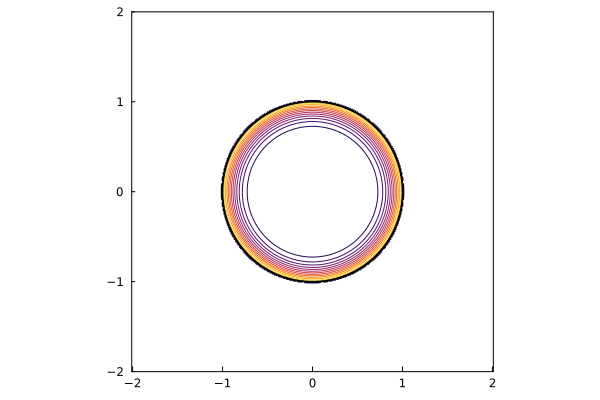

In [22]:
plot(state(integrator.u),sys)

It would be nice to just define a function called `temperature` to get this
more explicitly. We will do that here, and also apply a macro `@snapshotoutput` that
automatically extends this function with some convenient interfaces. For example,
if we simply pass in the integrator to `temperature`, it will pick off the `u`
field for us.

In [23]:
temperature(T,σ,x,sys::ILMSystem,t) = T
@snapshotoutput temperature

Now we can write

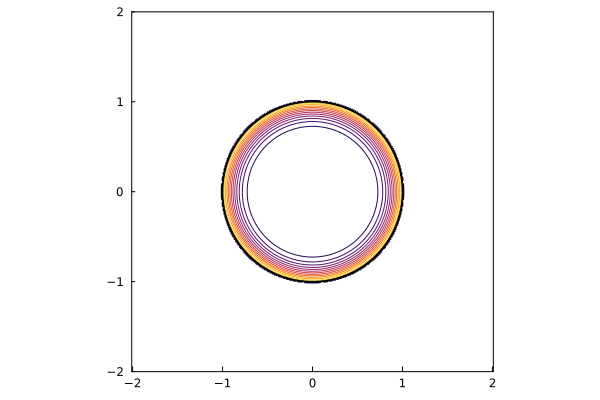

In [24]:
plot(temperature(integrator),sys)

The solution history is in the field `integrator.sol`. The macro we
called earlier enables temperature to work for this, as well, and
we can obtain the temperature at *any* time in the interval of our solution.
For example, to get the solution at time 0.51:

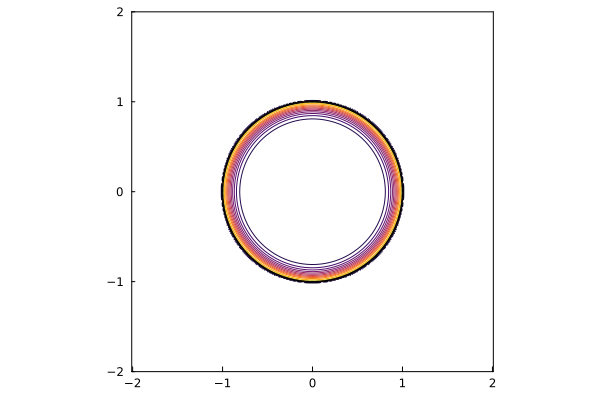

In [25]:
sol = integrator.sol
plot(temperature(sol,sys,0.0051),sys)

We can also get it for an array of times, e.g.,

In [26]:
temperature(sol,sys,0.0051:0.0001:0.0061);

## Motions
It is straightforward to make bodies move in time-varying problems,
using the `RigidBodyMotion` function. In the previous example
we used this in a trivial fashion. Here, we will use it
in a non-trivial example. The only caveat is that the time-stepping becomes slower
in such problems, since the system operators must be regenerated at
every time step.

The `RigidBodyTools.jl` package provides a versatile set of motions,
both rigid-body and deforming, and associated tools.

### Rigid body motion
For example, to simply make the body move at constant velocity 1 in the `x` direction.

In [27]:
Xp_to_jp = MotionTransform([0,0],0)
Xc_to_jc = MotionTransform([0,0],0)
dofs = [ConstantVelocityDOF(0),ConstantVelocityDOF(1),ConstantVelocityDOF(0)]
joint = Joint(FreeJoint2d,0,Xp_to_jp,1,Xc_to_jc,dofs)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


The `MotionTransform` operator `Xp_to_jp` places the parent side of the joint at the origin of the
inertial coordinate system (body 0) with no rotation, and `Xc_to_jc` places
the child side of the joint at the origin of the body's system (body 1), also with no rotation.
We are creating a *free* joint, with all degrees of freedom possibly in motion.

These three degrees of freedom are all assigned a prescribed behavior in the `dofs`
vector. They are ordered as [rotation, x position, y position].
The rotational and y degrees of freedom are all set to zero velocity
and the x degree is set to velocity of 1.

### Surface deformation
Deformations to the body surface can be superposed on rigid body
motions. Here's an example of a deforming motion on a stationary body

In [28]:
ufcn(x,y,t) = 0.25*x*y*cos(t)
vfcn(x,y,t) = 0.25*(x^2-y^2)*cos(t)
def = DeformationMotion(ufcn,vfcn)
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body,def)

1 linked system(s) of bodies
   1 bodies
   1 joints


Either of these would be provided in the `motions` keyword of the problem
construction. Consult the documentation of `RigidBodyTools.jl` to learn more
about these. However, for time-marching purposes, it is helpful to know that the
maximum surface velocity is provided by the `maxvelocity` function:

In [29]:
x = zero_motion_state(body,m)
maxvelocity(body,x,m)

(0.24998770586539437, 225, 0.0, 1)

The first element of the output is the maximum velocity,
the second is the index on which it occurs, the third is the time
at which it occurs, and the fourth is the body on which it occurs.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*